In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  RandomizedSearchCV,GridSearchCV
from sklearn.metrics import mean_absolute_error

In [3]:
df = yf.download("TSLA", start = "2012-05-01", end = "2022-05-01")["Adj Close"]

[*********************100%***********************]  1 of 1 completed


In [4]:
df = df.to_frame()
df['Close'] = df['Adj Close']
df = df.drop("Adj Close",axis=1)

In [5]:
df

,Close
Date,
2012-04-30,6.626000
2012-05-01,6.756000
2012-05-02,6.788000
2012-05-03,6.492000
2012-05-04,6.366000
...,...
2022-04-25,998.020020
2022-04-26,876.419983
2022-04-27,881.510010


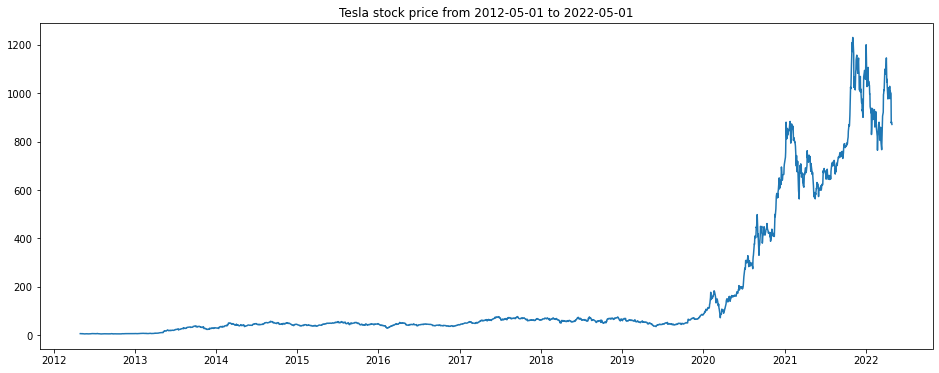

In [6]:
plt.figure(figsize=(16, 6))
plt.plot(df)
plt.title("Tesla stock price from 2012-05-01 to 2022-05-01")
plt.show()   

# Create More Features for my Model to Train

# Adding moving averages

In [7]:
for sma_period in [5,10,20,50,100,200]:
    indicator_name = "SMA_%d" % (sma_period)
    df[indicator_name] = df['Close'].rolling(sma_period).mean()

# Adding Bollinger bands

In [8]:
df['BollingerBand_Up_20_2'] = df['Close'].rolling(20).mean() + 2*df['Close'].rolling(20).std()
df['BollingerBand_Down_20_2'] = df['Close'].rolling(20).mean() - 2*df['Close'].rolling(20).std()


df['BollingerBand_Up_20_1'] = df['Close'].rolling(20).mean() + df['Close'].rolling(20).std()
df['BollingerBand_Down_20_1'] = df['Close'].rolling(20).mean() - df['Close'].rolling(20).std()

df['BollingerBand_Up_10_1'] = df['Close'].rolling(10).mean() + df['Close'].rolling(10).std()
df['BollingerBand_Down_10_1'] = df['Close'].rolling(10).mean() - df['Close'].rolling(10).std()

df['BollingerBand_Up_10_2'] = df['Close'].rolling(10).mean() + 2*df['Close'].rolling(10).std()
df['BollingerBand_Down_10_2'] = df['Close'].rolling(10).mean() - 2*df['Close'].rolling(10).std()

# Creating input features

In [9]:
newdata = df['Close'].to_frame()
for lag in [1,2,3,4,5,6,7,8,9,10]:
    shift = lag
    shifted = df.shift(shift)
    shifted.columns = [str.format("%s_shifted_by_%d" % (column ,shift)) for column in shifted.columns]
    newdata = pd.concat((newdata,shifted),axis=1)

# Creating target variable

In [10]:
forward_lag = 5

newdata['target'] = newdata['Close'].shift(-forward_lag)
newdata = newdata.drop('Close',axis=1)

newdata = newdata.dropna()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17568\4054800636.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdata['target'] = newdata['Close'].shift(-forward_lag)


In [11]:
newdata

,Close_shifted_by_1,SMA_5_shifted_by_1,SMA_10_shifted_by_1,SMA_20_shifted_by_1,SMA_50_shifted_by_1,SMA_100_shifted_by_1,SMA_200_shifted_by_1,BollingerBand_Up_20_2_shifted_by_1,BollingerBand_Down_20_2_shifted_by_1,BollingerBand_Up_20_1_shifted_by_1,...,SMA_200_shifted_by_10,BollingerBand_Up_20_2_shifted_by_10,BollingerBand_Down_20_2_shifted_by_10,BollingerBand_Up_20_1_shifted_by_10,BollingerBand_Down_20_1_shifted_by_10,BollingerBand_Up_10_1_shifted_by_10,BollingerBand_Down_10_1_shifted_by_10,BollingerBand_Up_10_2_shifted_by_10,BollingerBand_Down_10_2_shifted_by_10,target
Date,,,,,,,,,,,,,,,,,,,,,
2013-03-01,6.966000,6.994000,7.262800,7.474700,7.158400,6.670140,6.333140,8.167051,6.782349,7.820876,...,6.299090,8.085881,6.917319,7.793740,7.209460,7.820018,7.583582,7.938236,7.465364,7.694000
2013-03-04,6.930000,6.935600,7.190400,7.446100,7.159400,6.680840,6.335540,8.179729,6.712471,7.812915,...,6.303000,8.035993,7.020406,7.782097,7.274303,7.827155,7.526045,7.977709,7.375491,7.820000
2013-03-05,7.116000,6.983600,7.161200,7.418900,7.163360,6.693200,6.341060,8.159444,6.678356,7.789172,...,6.308500,8.010437,7.141163,7.793118,7.358481,7.860211,7.554589,8.013022,7.401778,7.824000
2013-03-06,7.330000,7.072400,7.108600,7.408000,7.171520,6.708720,6.348280,8.146959,6.669041,7.777479,...,6.313100,7.965633,7.252967,7.787466,7.431134,7.865734,7.565466,8.015868,7.415332,7.796000
2013-03-07,7.538000,7.176000,7.091600,7.403600,7.184560,6.725600,6.356790,8.138128,6.669072,7.770864,...,6.315800,8.002858,7.198942,7.801879,7.399921,7.891835,7.378965,8.148271,7.122529,7.370000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-18,985.000000,999.147998,1042.005994,1031.362988,926.253794,975.141194,889.689846,1155.484954,907.241023,1093.423971,...,872.638946,1170.116247,699.231726,1052.395117,816.952857,1098.258552,979.021404,1157.877127,919.402829,998.020020
2022-04-19,1004.289978,994.907996,1033.975995,1036.307986,928.516793,973.615394,891.321696,1146.383983,926.231990,1091.345985,...,875.249646,1196.666233,706.768734,1074.191858,829.243109,1113.313688,1008.824264,1165.558399,956.579552,876.419983
2022-04-20,1028.150024,1005.352002,1022.246002,1041.657489,930.613394,972.806594,893.067946,1137.672386,945.642592,1089.664938,...,877.601796,1209.880995,720.239971,1087.470739,842.650227,1117.972554,1023.621404,1165.148129,976.445829,881.510010


In [12]:
newdata.shape

(2304, 151)

# Training and test set

In [13]:
X = newdata.drop("target",axis=1)
Y = newdata['target']

train_size = int(X.shape[0]*0.7)

X_train = X[0:train_size]
y_train = Y[0:train_size]

X_test = X[train_size:]
y_test = Y[train_size:]

# Feature selection via Pearson correlation coeffficient

In [14]:
#As there are over 151 features in the datasets we pick the top 50 highest coefficient for training & testing. 
correlations = np.abs(X_train.corrwith(y_train))

features =  list(correlations.sort_values(ascending=False)[0:50].index)

In [15]:
X_train = X_train[features]
X_test = X_test[features]

# Linear regression

In [16]:
lr = LinearRegression()

lr.fit(X_train,y_train)

LinearRegression()

In [17]:
y_pred = lr.predict(X_test)

In [18]:
mean_absolute_error(y_test,y_pred)

42.41960007910977

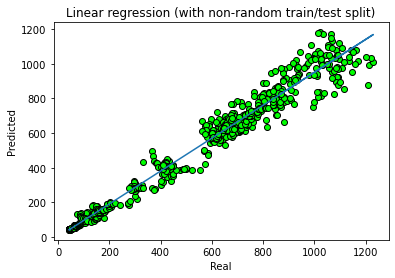

In [19]:
plt.scatter(y_test, y_pred, c='lime', edgecolor='black')
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m*y_test + b)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("Linear regression (with non-random train/test split)")
plt.show()   

# Random forest

In [20]:
rf = RandomizedSearchCV(RandomForestRegressor(),param_distributions =  {
                                'n_estimators':np.arange(10,500,5),
                                'max_features':np.arange(1,10,1)
                            },
                            cv=5, n_iter = 20,
                            random_state=0,refit=True,
                            scoring="neg_mean_absolute_error")

rf.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_features': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,
        75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135,
       140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200,
       205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265,
       270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330,
       335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395,
       400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460,
       465, 470, 475, 480, 485, 490, 495])},
                   random_state=0, scoring='neg_mean_absolute_error')

In [21]:
rf.best_params_

{'n_estimators': 255, 'max_features': 9}

In [22]:
y_pred = rf.predict(X_test)

In [23]:
mean_absolute_error(y_test,y_pred)

448.16292783049084

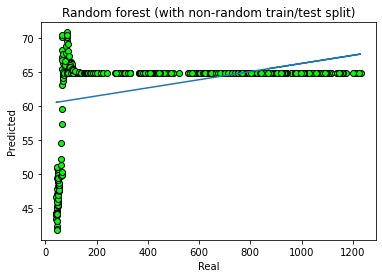

In [24]:
plt.scatter(y_test, y_pred, c='lime', edgecolor='black')
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m*y_test + b)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("Random forest (with non-random train/test split)")
plt.show()

# Gradient boosting regressor

In [25]:
gb = RandomizedSearchCV(GradientBoostingRegressor(),param_distributions =  {
                                'n_estimators':np.arange(10,500,5),
                                'max_features':np.arange(1,10,1)
                            },
                            cv=5, n_iter = 20,
                            random_state=0,refit=True,
                            scoring="neg_mean_absolute_error")

gb.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=20,
                   param_distributions={'max_features': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,
        75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135,
       140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200,
       205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265,
       270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330,
       335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395,
       400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460,
       465, 470, 475, 480, 485, 490, 495])},
                   random_state=0, scoring='neg_mean_absolute_error')

In [26]:
gb.best_params_

{'n_estimators': 85, 'max_features': 8}

In [27]:
y_pred = gb.predict(X_test)

In [28]:
mean_absolute_error(y_test,y_pred)

448.26785197108103

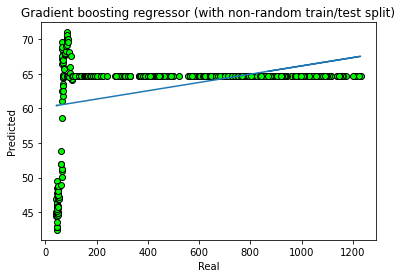

In [29]:
plt.scatter(y_test, y_pred, c='lime', edgecolor='black')
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m*y_test + b)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("Gradient boosting regressor (with non-random train/test split)")
plt.show()

# K Nearest Neighbors

In [30]:
knn = GridSearchCV(KNeighborsRegressor(),param_grid =  {
                                'n_neighbors':np.arange(1,20,1),
                                'weights':['distance','uniform']
                            },
                            cv=5, 
                            refit=True,
                            scoring="neg_mean_absolute_error")

knn.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'weights': ['distance', 'uniform']},
             scoring='neg_mean_absolute_error')

In [31]:
knn.best_params_

{'n_neighbors': 19, 'weights': 'uniform'}

In [32]:
y_pred = knn.predict(X_test)

In [33]:
mean_absolute_error(y_test,y_pred)

445.5859685256048

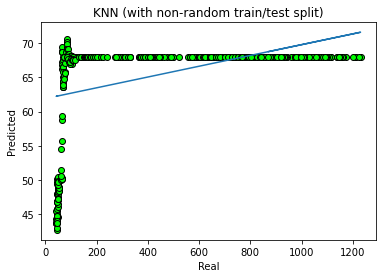

In [34]:
plt.scatter(y_test, y_pred, c='lime', edgecolor='black')
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m*y_test + b)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("KNN (with non-random train/test split)")
plt.show()

# Neural network

In [35]:
scaler = MinMaxScaler()

scaler.fit(X_train)

nnet = RandomizedSearchCV(MLPRegressor(max_iter=5000,learning_rate = 'adaptive',solver='sgd'),param_distributions =  {
                                'hidden_layer_sizes':[(x,) for x in np.arange(1,50,1)],
                                'activation':['logistic','relu']
                            },
                            cv=5, n_iter = 20,
                            random_state=0,refit=True,
                            scoring="neg_mean_absolute_error")

In [36]:
nnet.fit(scaler.transform(X_train),y_train)

RandomizedSearchCV(cv=5,
                   estimator=MLPRegressor(learning_rate='adaptive',
                                          max_iter=5000, solver='sgd'),
                   n_iter=20,
                   param_distributions={'activation': ['logistic', 'relu'],
                                        'hidden_layer_sizes': [(1,), (2,), (3,),
                                                               (4,), (5,), (6,),
                                                               (7,), (8,), (9,),
                                                               (10,), (11,),
                                                               (12,), (13,),
                                                               (14,), (15,),
                                                               (16,), (17,),
                                                               (18,), (19,),
                                                               (20,), (21,),
                        

In [37]:
y_pred = nnet.predict(scaler.transform(X_test))

In [38]:
nnet.best_params_

{'hidden_layer_sizes': (23,), 'activation': 'relu'}

In [39]:
mean_absolute_error(y_test,y_pred)

45.37511151052321

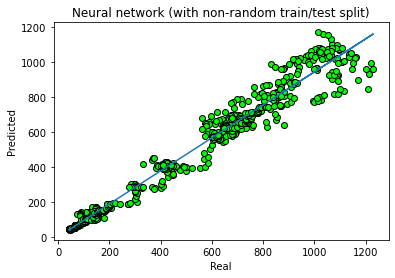

In [40]:
plt.scatter(y_test, y_pred, c='lime', edgecolor='black')
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m*y_test + b)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("Neural network (with non-random train/test split)")
plt.show()

# Linear regression with Bagging

In [41]:
lr_bag = RandomizedSearchCV(BaggingRegressor(LinearRegression()),param_distributions =  {
                                'n_estimators':np.arange(10,500,5),
                                'max_features':np.arange(1,10,1)
                            },
                            cv=5, n_iter = 20,
                            random_state=0,refit=True,
                            scoring="neg_mean_absolute_error")

lr_bag.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=BaggingRegressor(base_estimator=LinearRegression()),
                   n_iter=20,
                   param_distributions={'max_features': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,
        75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135,
       140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200,
       205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265,
       270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330,
       335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395,
       400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460,
       465, 470, 475, 480, 485, 490, 495])},
                   random_state=0, scoring='neg_mean_absolute_error')

In [42]:
y_pred = lr_bag.predict(X_test)

In [43]:
lr_bag.best_params_

{'n_estimators': 365, 'max_features': 9}

In [44]:
mean_absolute_error(y_test,y_pred)

44.63833804555751

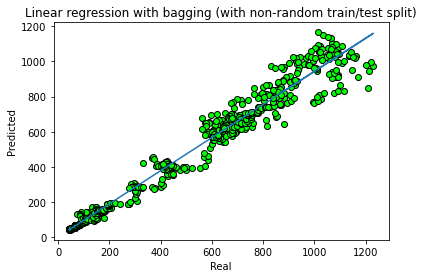

In [45]:
plt.scatter(y_test, y_pred, c='lime', edgecolor='black')
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m*y_test + b)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("Linear regression with bagging (with non-random train/test split)")
plt.show()

# Linear regression with Adaboost

In [46]:
lr_boost = GridSearchCV(AdaBoostRegressor(LinearRegression()),param_grid =  {
                                'n_estimators':np.arange(20,500,5)
                            },
                            cv=5, 
                            refit=True,
                            scoring="neg_mean_absolute_error")

lr_boost.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=AdaBoostRegressor(base_estimator=LinearRegression()),
             param_grid={'n_estimators': array([ 20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,  75,  80,
        85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145,
       150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210,
       215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275,
       280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340,
       345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405,
       410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470,
       475, 480, 485, 490, 495])},
             scoring='neg_mean_absolute_error')

In [47]:
y_pred = lr_boost.predict(X_test)

In [48]:
lr_boost.best_params_

{'n_estimators': 165}

In [49]:
mean_absolute_error(y_test,y_pred)

43.03194206392055

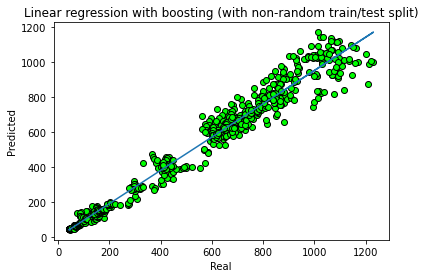

In [50]:
plt.scatter(y_test, y_pred, c='lime', edgecolor='black')
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m*y_test + b)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("Linear regression with boosting (with non-random train/test split)")
plt.show()